### Install Package yang diperlukan

In [1]:
!pip install jcopdl
!pip install tqdm

### Siapkan Package yang diperlukan


In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block

from google.colab import files
import zipfile,os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Siapkan Datasets

In [3]:
local_zip = '/content/CIFAR10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

base_dir = ('/content/cifar10/cifar10')
os.listdir(base_dir)

['train', 'test']

In [4]:
bs = 256
crop_size = 32

transform_data = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/cifar10/cifar10/train", transform=transform_data)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/cifar10/cifar10/test", transform=transform_data)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
images, label = next(iter(trainloader))
images.shape

torch.Size([256, 3, 32, 32])

In [6]:
label2cat = train_set.classes
label2cat

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Arsitektur dan Config

In [14]:
class CifarClf(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, drout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=drout),
            linear_block(n1, n2, dropout=drout),
            linear_block(n2, output_size, activation='lsoftmax')
        )
    
    def forward(self, x):
        return self.fc(x)

In [15]:
config = set_config({
    "input_size" : 3072,
    "n1" : 2048,
    "n2" : 1024,
    "output_size" : len(label2cat),
    "drout" : 0.2,
    "bs" : 256
})

### Training Preparation -> MCOC

In [16]:
model = CifarClf(config.input_size, config.n1, config.n2, config.output_size, config.drout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)
callback = Callback(model, config, outdir="model_weight", early_stop_patience=15)

### Proses Training

In [17]:
from tqdm.auto import tqdm

# Buat Training fungsi
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 2.0767 | Test_cost  = 1.7821 | Train_score = 0.2742 | Test_score = 0.3623 |




Epoch     2
Train_cost  = 1.7959 | Test_cost  = 1.7105 | Train_score = 0.3504 | Test_score = 0.3985 |




Epoch     3
Train_cost  = 1.7517 | Test_cost  = 1.6843 | Train_score = 0.3700 | Test_score = 0.3890 |
==> EarlyStop patience =  1 | Best test_score: 0.3985




Epoch     4
Train_cost  = 1.7201 | Test_cost  = 1.6532 | Train_score = 0.3811 | Test_score = 0.4093 |




Epoch     5
Train_cost  = 1.6999 | Test_cost  = 1.6055 | Train_score = 0.3856 | Test_score = 0.4261 |




Epoch     6
Train_cost  = 1.6710 | Test_cost  = 1.6119 | Train_score = 0.3958 | Test_score = 0.4213 |
==> EarlyStop patience =  1 | Best test_score: 0.4261




Epoch     7
Train_cost  = 1.6600 | Test_cost  = 1.5933 | Train_score = 0.3979 | Test_score = 0.4305 |




Epoch     8
Train_cost  = 1.6371 | Test_cost  = 1.6651 | Train_score = 0.4114 | Test_score = 0.4119 |
==> EarlyStop patience =  1 | Best test_score: 0.4305




Epoch     9
Train_cost  = 1.6146 | Test_cost  = 1.5636 | Train_score = 0.4162 | Test_score = 0.4430 |




Epoch    10
Train_cost  = 1.6162 | Test_cost  = 1.5543 | Train_score = 0.4173 | Test_score = 0.4516 |




Epoch    11
Train_cost  = 1.5976 | Test_cost  = 1.5399 | Train_score = 0.4230 | Test_score = 0.4473 |
==> EarlyStop patience =  1 | Best test_score: 0.4516




Epoch    12
Train_cost  = 1.5924 | Test_cost  = 1.5730 | Train_score = 0.4249 | Test_score = 0.4367 |
==> EarlyStop patience =  2 | Best test_score: 0.4516




Epoch    13
Train_cost  = 1.5826 | Test_cost  = 1.5569 | Train_score = 0.4294 | Test_score = 0.4473 |
==> EarlyStop patience =  3 | Best test_score: 0.4516




Epoch    14
Train_cost  = 1.5767 | Test_cost  = 1.5626 | Train_score = 0.4286 | Test_score = 0.4402 |
==> EarlyStop patience =  4 | Best test_score: 0.4516




Epoch    15
Train_cost  = 1.5615 | Test_cost  = 1.5007 | Train_score = 0.4362 | Test_score = 0.4640 |




Epoch    16
Train_cost  = 1.5668 | Test_cost  = 1.5616 | Train_score = 0.4347 | Test_score = 0.4439 |
==> EarlyStop patience =  1 | Best test_score: 0.4640




Epoch    17
Train_cost  = 1.5583 | Test_cost  = 1.5363 | Train_score = 0.4393 | Test_score = 0.4528 |
==> EarlyStop patience =  2 | Best test_score: 0.4640




Epoch    18
Train_cost  = 1.5482 | Test_cost  = 1.5374 | Train_score = 0.4408 | Test_score = 0.4415 |
==> EarlyStop patience =  3 | Best test_score: 0.4640




Epoch    19
Train_cost  = 1.5425 | Test_cost  = 1.5353 | Train_score = 0.4430 | Test_score = 0.4507 |
==> EarlyStop patience =  4 | Best test_score: 0.4640




Epoch    20
Train_cost  = 1.5413 | Test_cost  = 1.5230 | Train_score = 0.4442 | Test_score = 0.4589 |


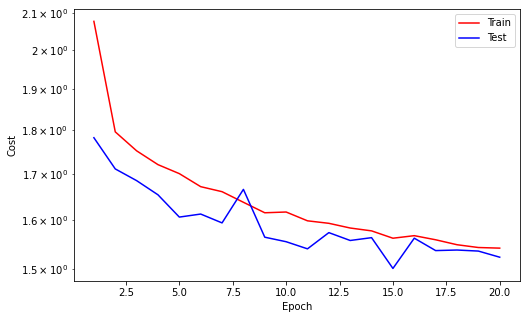

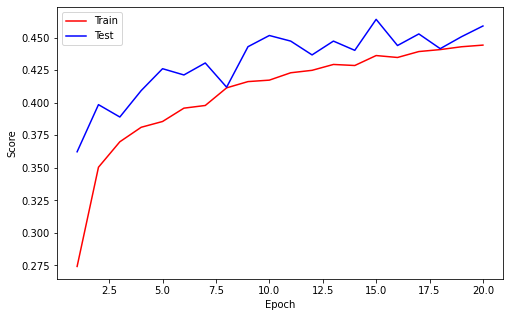

==> EarlyStop patience =  5 | Best test_score: 0.4640




Epoch    21
Train_cost  = 1.5261 | Test_cost  = 1.4973 | Train_score = 0.4495 | Test_score = 0.4687 |




Epoch    22
Train_cost  = 1.5351 | Test_cost  = 1.5018 | Train_score = 0.4455 | Test_score = 0.4614 |
==> EarlyStop patience =  1 | Best test_score: 0.4687




Epoch    23
Train_cost  = 1.5222 | Test_cost  = 1.4922 | Train_score = 0.4518 | Test_score = 0.4761 |




Epoch    24
Train_cost  = 1.5053 | Test_cost  = 1.4899 | Train_score = 0.4583 | Test_score = 0.4715 |
==> EarlyStop patience =  1 | Best test_score: 0.4761




Epoch    25
Train_cost  = 1.5115 | Test_cost  = 1.4904 | Train_score = 0.4563 | Test_score = 0.4694 |
==> EarlyStop patience =  2 | Best test_score: 0.4761




Epoch    26
Train_cost  = 1.5249 | Test_cost  = 1.4899 | Train_score = 0.4518 | Test_score = 0.4654 |
==> EarlyStop patience =  3 | Best test_score: 0.4761




Epoch    27
Train_cost  = 1.5011 | Test_cost  = 1.5048 | Train_score = 0.4617 | Test_score = 0.4578 |
==> EarlyStop patience =  4 | Best test_score: 0.4761




Epoch    28
Train_cost  = 1.5112 | Test_cost  = 1.4788 | Train_score = 0.4561 | Test_score = 0.4749 |
==> EarlyStop patience =  5 | Best test_score: 0.4761




Epoch    29
Train_cost  = 1.5065 | Test_cost  = 1.5125 | Train_score = 0.4554 | Test_score = 0.4595 |
==> EarlyStop patience =  6 | Best test_score: 0.4761




Epoch    30
Train_cost  = 1.5092 | Test_cost  = 1.4748 | Train_score = 0.4551 | Test_score = 0.4836 |




Epoch    31
Train_cost  = 1.4938 | Test_cost  = 1.4918 | Train_score = 0.4634 | Test_score = 0.4701 |
==> EarlyStop patience =  1 | Best test_score: 0.4836




Epoch    32
Train_cost  = 1.4934 | Test_cost  = 1.4963 | Train_score = 0.4617 | Test_score = 0.4714 |
==> EarlyStop patience =  2 | Best test_score: 0.4836




Epoch    33
Train_cost  = 1.4872 | Test_cost  = 1.4584 | Train_score = 0.4648 | Test_score = 0.4835 |
==> EarlyStop patience =  3 | Best test_score: 0.4836




Epoch    34
Train_cost  = 1.4893 | Test_cost  = 1.4879 | Train_score = 0.4648 | Test_score = 0.4711 |
==> EarlyStop patience =  4 | Best test_score: 0.4836




Epoch    35
Train_cost  = 1.4935 | Test_cost  = 1.4810 | Train_score = 0.4623 | Test_score = 0.4755 |
==> EarlyStop patience =  5 | Best test_score: 0.4836




Epoch    36
Train_cost  = 1.4832 | Test_cost  = 1.5103 | Train_score = 0.4638 | Test_score = 0.4780 |
==> EarlyStop patience =  6 | Best test_score: 0.4836




Epoch    37
Train_cost  = 1.4769 | Test_cost  = 1.4563 | Train_score = 0.4672 | Test_score = 0.4811 |
==> EarlyStop patience =  7 | Best test_score: 0.4836




Epoch    38
Train_cost  = 1.4894 | Test_cost  = 1.4869 | Train_score = 0.4632 | Test_score = 0.4716 |
==> EarlyStop patience =  8 | Best test_score: 0.4836




Epoch    39
Train_cost  = 1.4771 | Test_cost  = 1.4556 | Train_score = 0.4676 | Test_score = 0.4820 |
==> EarlyStop patience =  9 | Best test_score: 0.4836




Epoch    40
Train_cost  = 1.4718 | Test_cost  = 1.4944 | Train_score = 0.4711 | Test_score = 0.4742 |


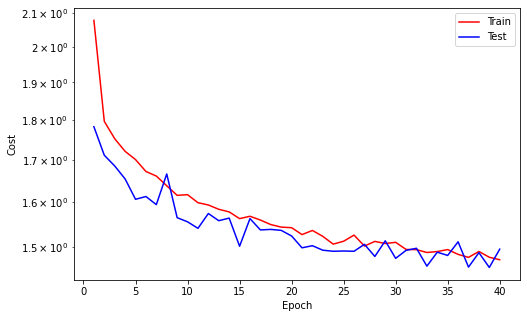

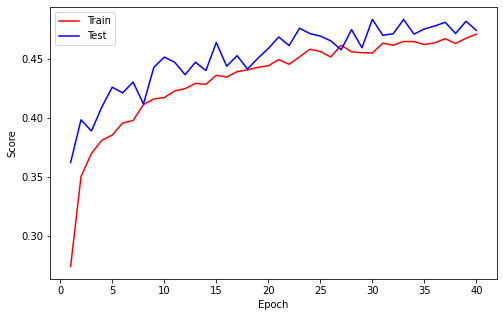

==> EarlyStop patience = 10 | Best test_score: 0.4836




Epoch    41
Train_cost  = 1.4574 | Test_cost  = 1.4650 | Train_score = 0.4755 | Test_score = 0.4817 |
==> EarlyStop patience = 11 | Best test_score: 0.4836




Epoch    42
Train_cost  = 1.4582 | Test_cost  = 1.4831 | Train_score = 0.4769 | Test_score = 0.4744 |
==> EarlyStop patience = 12 | Best test_score: 0.4836




Epoch    43
Train_cost  = 1.4583 | Test_cost  = 1.4847 | Train_score = 0.4764 | Test_score = 0.4734 |
==> EarlyStop patience = 13 | Best test_score: 0.4836




Epoch    44
Train_cost  = 1.4587 | Test_cost  = 1.4896 | Train_score = 0.4750 | Test_score = 0.4694 |
==> EarlyStop patience = 14 | Best test_score: 0.4836




Epoch    45
Train_cost  = 1.4660 | Test_cost  = 1.4937 | Train_score = 0.4741 | Test_score = 0.4688 |
==> EarlyStop patience = 15 | Best test_score: 0.4836
==> Execute Early Stopping at epoch: 45 | Best test_score: 0.4836
==> Best model is saved at model_weight


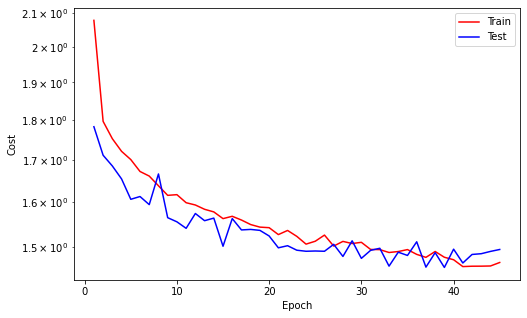

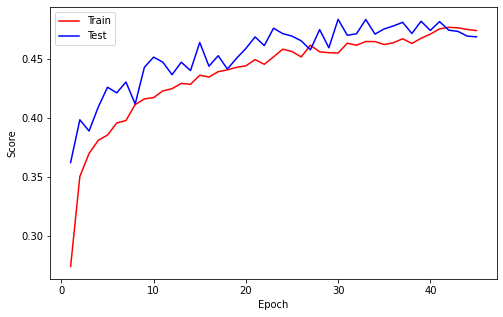

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break